In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Classifying Emotion in Audio Clips

Analyzing audio recordings and identify the emotions expressed in the speech

## Reading Datasets

In [4]:
curr_dir = os.getcwd()

ravdess_path = os.path.join(curr_dir, "data_ravdess")
crema_path = os.path.join(curr_dir, "data_crema")
tess_path = os.path.join(curr_dir, "data_tess")
savee_path = os.path.join(curr_dir, "data_savee")

### Ravdess

The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [5]:
# ravdess key:value pairs 
emotions_convert = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

In [6]:
data = []

# Process files and store relevant data
for actor in os.listdir(ravdess_path):
    if 'Actor' in actor:
        actor_folder_path = os.path.join(ravdess_path, actor)
        for audio_file in os.listdir(actor_folder_path):
            file_name = audio_file.split('.')[0]
            parts = file_name.split('-')

            emotion_key = parts[2]
            gender_identifier = int(parts[6])
            gender = 'female' if gender_identifier % 2 == 0 else 'male'

            # Store each row's data as a dictionary
            data.append({
                'Path': os.path.join(actor_folder_path, audio_file),
                'Sex': gender,
                'Emotion': emotions_convert.get(emotion_key, 'Unknown')  # Use get to handle missing keys
            })

# Create DataFrame from the list of dictionaries
Ravdess_df = pd.DataFrame(data)

Ravdess_df

Path     Sex  Emotion
0     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    angry
1     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     fear
2     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     fear
3     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    angry
4     /Users/gabrielcha/Documents/ser/data_ravdess/A...  female  disgust
...                                                 ...     ...      ...
1435  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    happy
1436  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female    happy
1437  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     calm
1438  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     calm
1439  /Users/gabrielcha/Documents/ser/data_ravdess/A...  female  neutral

[1440 rows x 3 columns]

### Crema

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [7]:
# crema key:value pairs 
emotion_mapping = {
    'SAD': 'sad',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral'
}

# actor's info
crema_actor_info = pd.read_csv('VideoDemographics.csv', usecols=['ActorID', 'Sex'])

In [8]:
data = []

# Process files and store relevant data
for file in os.listdir(crema_path):
    file_path = os.path.join(crema_path, file)
    parts = file.split('_')
    actor_info = parts[0]
    emotion_code = parts[2]

    # Append each row's data as a dictionary
    data.append({
        'Path': file_path,
        'ActorID': actor_info,
        'Emotion': emotion_mapping.get(emotion_code, 'Unknown')  # Handle unknown emotions
    })

# Create DataFrame from the list of dictionaries
Crema_df = pd.DataFrame(data)

# retrieve actor's info
Crema_df['ActorID'] = Crema_df['ActorID'].astype(int)
merged_df = pd.merge(Crema_df, crema_actor_info, left_on = 'ActorID', right_on = 'ActorID', how = 'left')
Crema_df = merged_df[['Path', 'Emotion', 'Sex']]
Crema_df['Sex'] = Crema_df['Sex'].str.lower()

Crema_df

Path  Emotion     Sex
0     /Users/gabrielcha/Documents/ser/data_crema/102...    angry    male
1     /Users/gabrielcha/Documents/ser/data_crema/103...    angry  female
2     /Users/gabrielcha/Documents/ser/data_crema/106...  neutral  female
3     /Users/gabrielcha/Documents/ser/data_crema/107...  neutral  female
4     /Users/gabrielcha/Documents/ser/data_crema/107...  disgust  female
...                                                 ...      ...     ...
7437  /Users/gabrielcha/Documents/ser/data_crema/108...    angry  female
7438  /Users/gabrielcha/Documents/ser/data_crema/102...    angry  female
7439  /Users/gabrielcha/Documents/ser/data_crema/103...    angry  female
7440  /Users/gabrielcha/Documents/ser/data_crema/101...    angry    male
7441  /Users/gabrielcha/Documents/ser/data_crema/107...  neutral  female

[7442 rows x 3 columns]

### Tess

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format



In [9]:
data = []

# Process files and store relevant data
for dir_name in os.listdir(tess_path):
    dir_path = os.path.join(tess_path, dir_name)
    for file in os.listdir(dir_path):
        # print(file)
        file_name = file.split('.')[0]
        parts = file_name.split('_')
        if len(parts) > 2:
            emotion_part = parts[2]
            if emotion_part=='ps': emotion = 'surprise'
            else: emotion = emotion_part
            # Append each row's data as a dictionary
            data.append({
                'Path': os.path.join(dir_path, file),
                'Emotion': emotion, 
                'Sex': 'female'
            })

# Create DataFrame from the list of dictionaries
Tess_df = pd.DataFrame(data)

Tess_df

Path  Emotion     Sex
0     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
1     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
2     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
3     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
4     /Users/gabrielcha/Documents/ser/data_tess/YAF_...  disgust  female
...                                                 ...      ...     ...
2795  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2796  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2797  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2798  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female
2799  /Users/gabrielcha/Documents/ser/data_tess/OAF_...      sad  female

[2800 rows x 3 columns]

### Savee 

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. A neutral category is also added to provide recordings of 7 emotion categories.

In [10]:
# dictionary to map short emotion codes to full names
emotion_mapping = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'  
}

In [11]:
data = []


for file in os.listdir(savee_path):
    file_path = os.path.join(savee_path, file)
    part = file.split('_')[1][:-6]  # Get the emotion code, trimming the last 6 characters

    # Use the dictionary to get the full emotion name, default to 'surprise' if not found
    emotion = emotion_mapping.get(part, 'surprise')
    
    # Append each row's data as a dictionary
    data.append({
        'Path': file_path,
        'Emotion': emotion,
        'Sex' : 'male'
    })

# Create DataFrame from the list of dictionaries
Savee_df = pd.DataFrame(data)

Savee_df

Path   Emotion   Sex
0    /Users/gabrielcha/Documents/ser/data_savee/JK_...       sad  male
1    /Users/gabrielcha/Documents/ser/data_savee/JK_...       sad  male
2    /Users/gabrielcha/Documents/ser/data_savee/DC_...   neutral  male
3    /Users/gabrielcha/Documents/ser/data_savee/DC_...  surprise  male
4    /Users/gabrielcha/Documents/ser/data_savee/DC_...   neutral  male
..                                                 ...       ...   ...
475  /Users/gabrielcha/Documents/ser/data_savee/JE_...     angry  male
476  /Users/gabrielcha/Documents/ser/data_savee/JE_...     angry  male
477  /Users/gabrielcha/Documents/ser/data_savee/DC_...   neutral  male
478  /Users/gabrielcha/Documents/ser/data_savee/DC_...  surprise  male
479  /Users/gabrielcha/Documents/ser/data_savee/DC_...  surprise  male

[480 rows x 3 columns]

## Audio Files

In [12]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
dataset = data_path.reset_index(drop=['index'])
dataset.to_csv("data_path.csv",index=False)
dataset['Emotion'] = dataset['Emotion'].replace('surprised', 'surprise')
dataset

Path     Sex   Emotion
0      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
1      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
2      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
3      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
4      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female   disgust
...                                                  ...     ...       ...
12157  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12158  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12159  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male   neutral
12160  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise
12161  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise

[12162 rows x 3 columns]

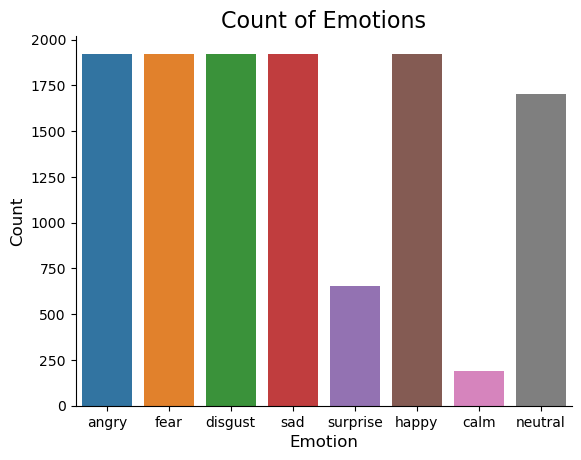

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(dataset.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotion', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

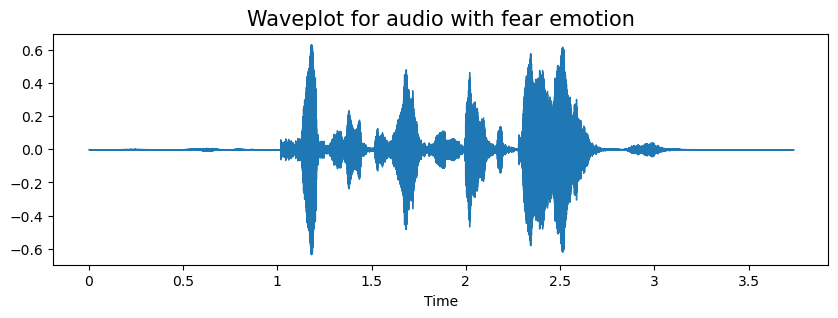

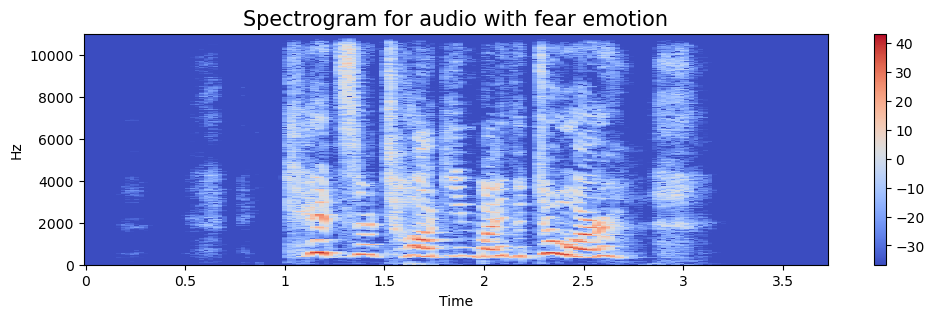

In [15]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


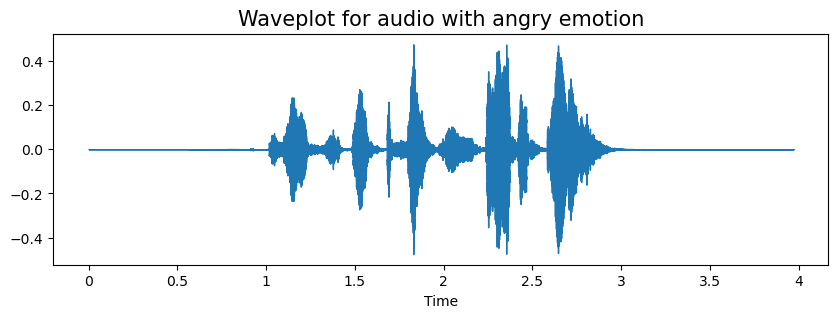

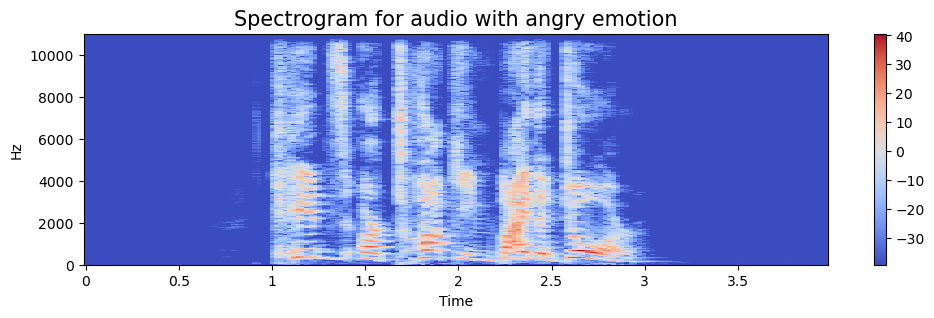

In [16]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

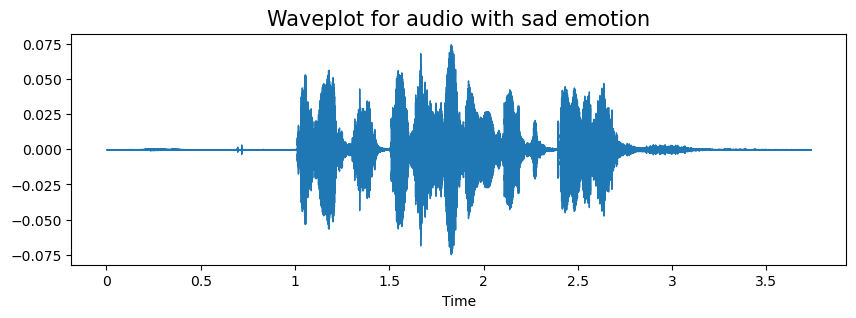

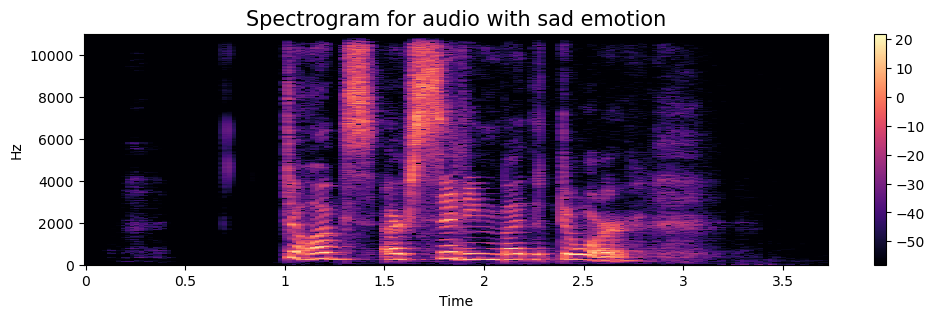

In [17]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

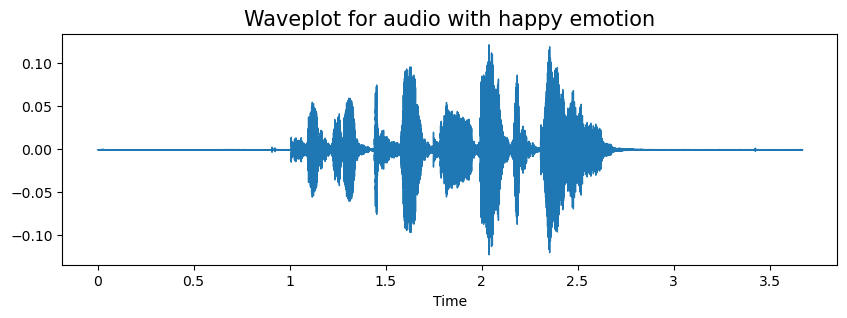

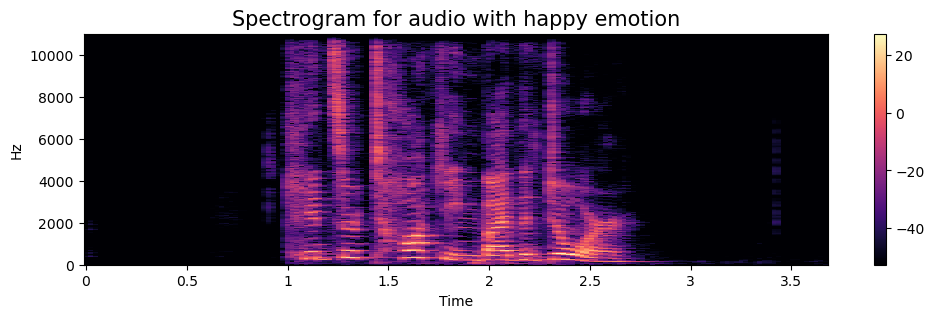

In [18]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [19]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate1=0.8):
    return librosa.effects.time_stretch(data, rate = rate1)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

#not using pitch
def pitch(data, sampling_rate, pitch_factor1=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor = pitch_factor1)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)



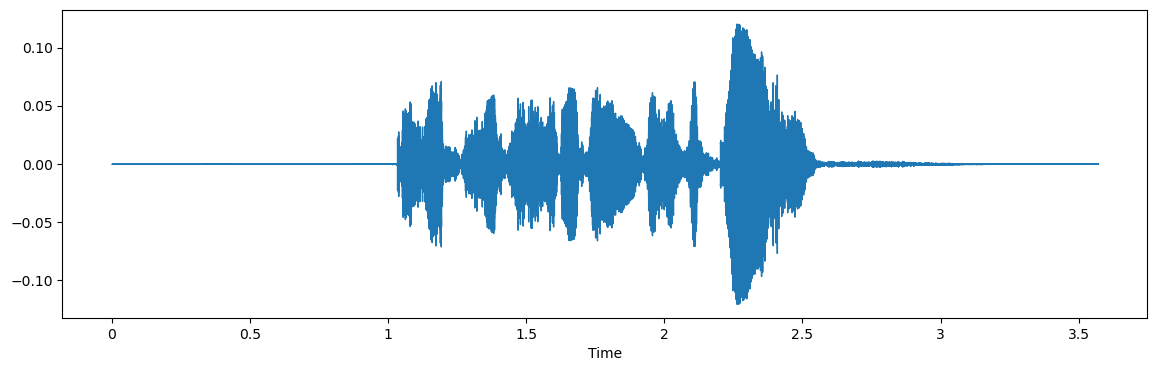

In [20]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

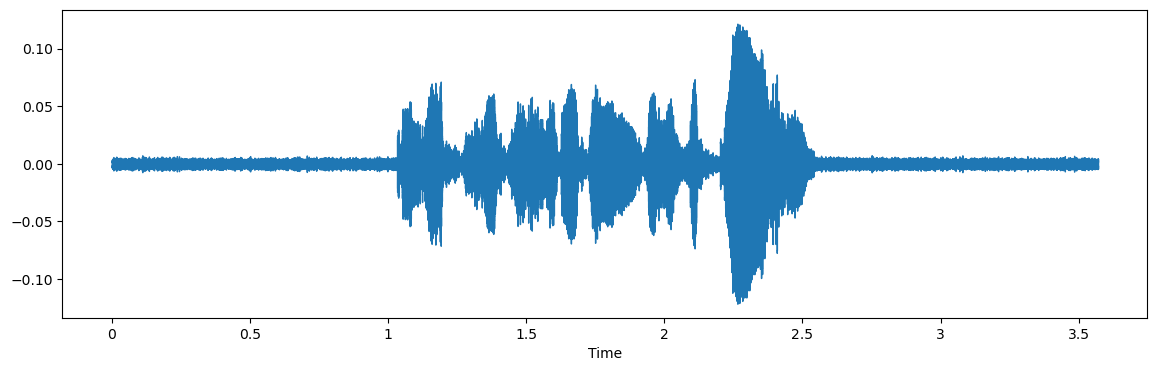

In [21]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

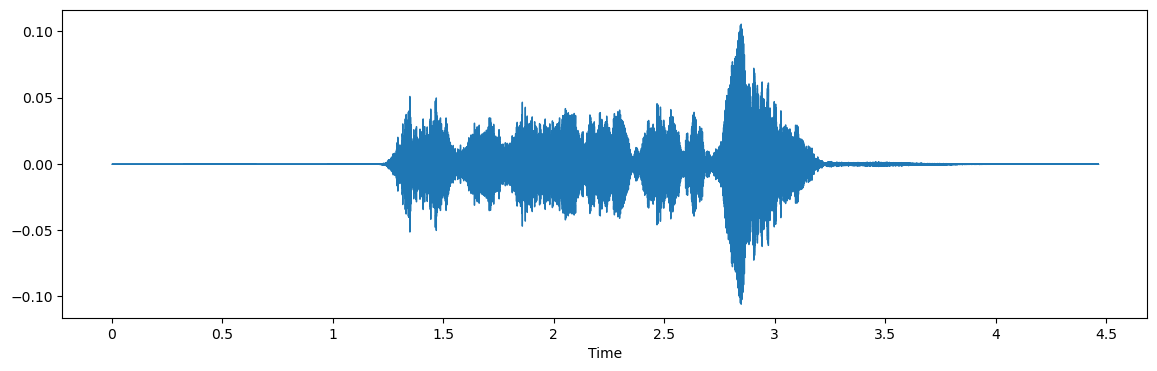

In [22]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

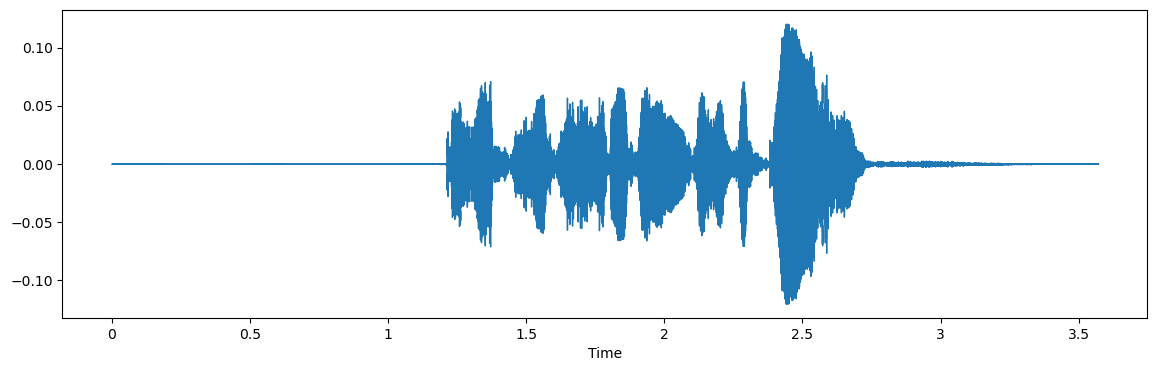

In [23]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [133]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [134]:
path = df['path'].loc[0]

data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

result = np.array([])


# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

In [135]:

# without augmentation
res1 = extract_features(data)

# Chroma_stft
stft = np.abs(librosa.stft(data))


chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

In [136]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    #data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(new_data)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [154]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [71]:
Features = pd.read_csv('features.csv')
Features = Features.sample(frac=1).reset_index(drop=True) 
X = Features.iloc[: ,:-2]
Y = Features['labels_emotion'].values

In [72]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.158366  0.607709  0.640193  0.771080  0.762258  0.686358  0.719792   
1  0.051368  0.522929  0.634474  0.739429  0.748630  0.690037  0.687318   
2  0.082003  0.537244  0.561132  0.529565  0.524751  0.494402  0.530222   
3  0.131389  0.681466  0.701092  0.722501  0.804850  0.717197  0.657836   
4  0.049825  0.667963  0.622340  0.661632  0.631178  0.722087  0.697093   

          7         8         9  ...           153           154  \
0  0.638771  0.576396  0.628893  ...  5.422068e-05  6.583735e-05   
1  0.670473  0.649922  0.633631  ...  8.425140e-10  7.123043e-10   
2  0.646638  0.671289  0.623182  ...  1.403624e-05  9.909627e-06   
3  0.647904  0.660125  0.706870  ...  2.220254e-06  4.405134e-06   
4  0.663124  0.623208  0.658223  ...  1.600570e-07  1.472409e-07   

            155           156           157           158           159  \
0  9.661225e-05  8.524146e-05  6.582148e-05  5.916481e-05  4.463777e-05   
1  6.283431e-10  5.706645e-10  5.300443e-10  5.014869e-10  4.812776e-10   
2  1.249449e-05  1.419258e-05  1.337191e-05  8.686337e-06  1.394909e-05   
3  1.093365e-05  1.374223e-05  7.400650e-06  5.354248e-06  4.327914e-06   
4  1.381570e-07  1.314036e-07  1.263641e-07  1.227247e-07  1.200765e-07   

            160           161   labels  
0  1.815374e-05  1.626830e-06  disgust  
1  4.680590e-10  4.601702e-10  disgust  
2  9.275916e-06  6.968180e-07  disgust  
3  3.157392e-06  1.822653e-07     calm  
4  1.183501e-07  1.172812e-07    angry  

[5 rows x 163 columns]

In [73]:
Features = Features.sample(frac=1).reset_index(drop=True) 

In [225]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [25]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [27]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [28]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [60]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 21, 128)          

In [61]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2024-06-01 17:19:49.475447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 1.9276 - accuracy: 0.2816

2024-06-01 17:19:55.710320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 8s 17ms/step - loss: 1.9276 - accuracy: 0.2816 - val_loss: 1.6708 - val_accuracy: 0.3534 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 7s 16ms/step - loss: 1.8797 - accuracy: 0.3491 - val_loss: 1.4830 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 7s 17ms/step - loss: 1.7419 - accuracy: 0.3847 - val_loss: 1.4510 - val_accuracy: 0.4272 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 7s 16ms/step - loss: 1.5966 - accuracy: 0.4171 - val_loss: 1.3426 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 7s 16ms/step - loss: 1.5970 - accuracy: 0.4128 - val_loss: 1.4277 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 7s 16ms/step - loss: 1.5333 - accuracy: 0.4248 - val_loss: 1.3099 - val_accuracy: 0.4758 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 7s 16ms/step - loss: 

286/286 [==============================] - 2s 8ms/step - loss: 1.3231 - accuracy: 0.4851
Accuracy of our model on test data :  48.50910007953644 %


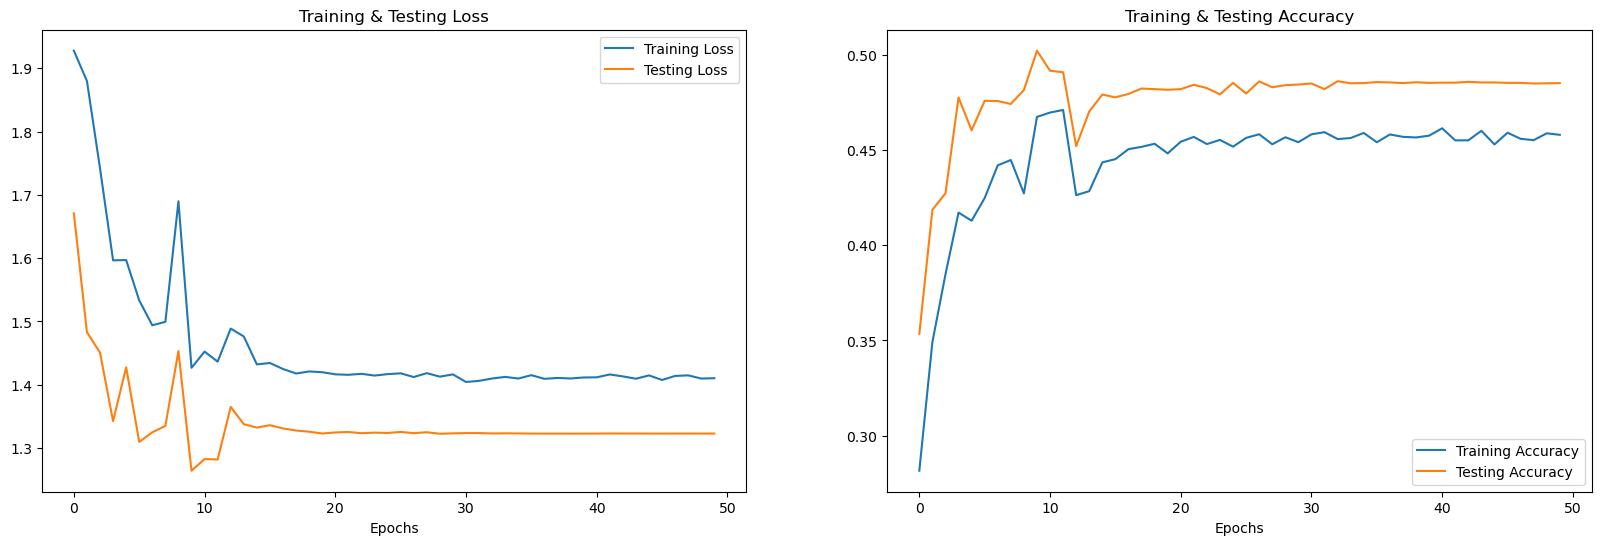

In [63]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [64]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

 23/286 [=>............................] - ETA: 1s

2024-06-01 17:25:50.218123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 1s 3ms/step


In [65]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust           sad
1             fear          fear
2             fear          fear
3          disgust       disgust
4            happy      surprise
5              sad         happy
6            angry          fear
7              sad           sad
8              sad       neutral
9            angry         angry

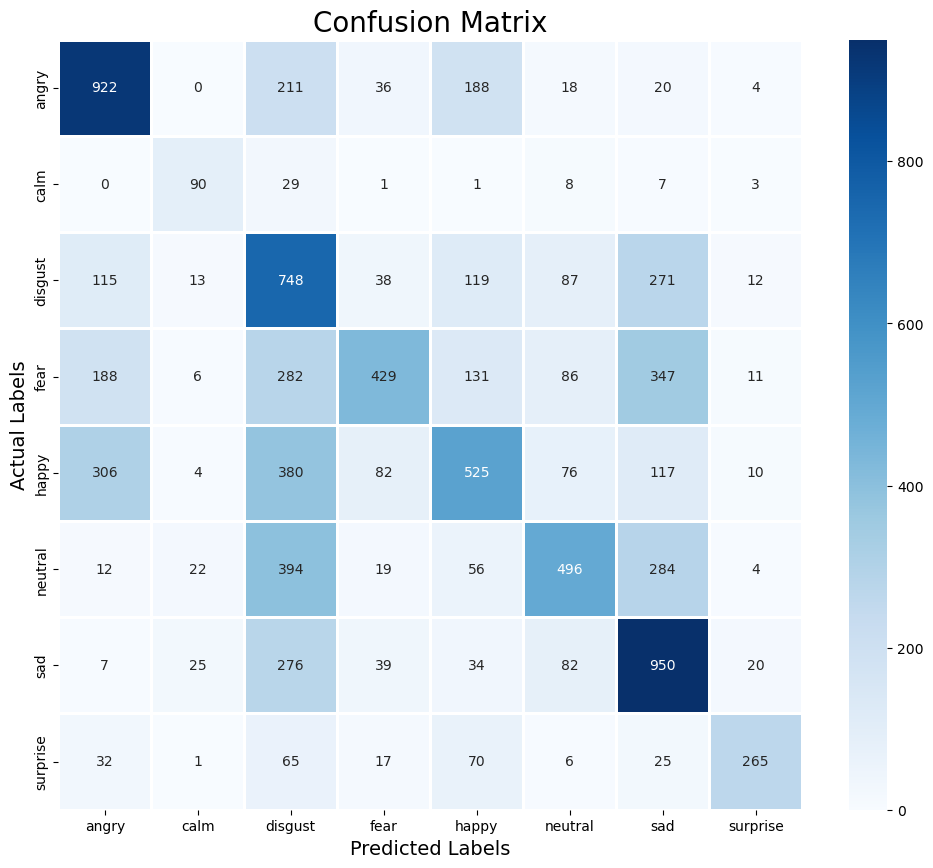

In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.58      0.66      0.62      1399
        calm       0.56      0.65      0.60       139
     disgust       0.31      0.53      0.39      1403
        fear       0.65      0.29      0.40      1480
       happy       0.47      0.35      0.40      1500
     neutral       0.58      0.39      0.46      1287
         sad       0.47      0.66      0.55      1433
    surprise       0.81      0.55      0.65       481

    accuracy                           0.49      9122
   macro avg       0.55      0.51      0.51      9122
weighted avg       0.53      0.49      0.48      9122



In [68]:
report = classification_report(y_test, y_pred, output_dict=True)
report

{'angry': {'precision': 0.5828065739570164,
  'recall': 0.6590421729807004,
  'f1-score': 0.6185843676618584,
  'support': 1399},
 'calm': {'precision': 0.5590062111801242,
  'recall': 0.6474820143884892,
  'f1-score': 0.6,
  'support': 139},
 'disgust': {'precision': 0.31362683438155137,
  'recall': 0.5331432644333571,
  'f1-score': 0.39493136219640973,
  'support': 1403},
 'fear': {'precision': 0.649016641452345,
  'recall': 0.28986486486486485,
  'f1-score': 0.4007473143390939,
  'support': 1480},
 'happy': {'precision': 0.46708185053380785,
  'recall': 0.35,
  'f1-score': 0.40015243902439024,
  'support': 1500},
 'neutral': {'precision': 0.5774155995343423,
  'recall': 0.3853923853923854,
  'f1-score': 0.46225535880708296,
  'support': 1287},
 'sad': {'precision': 0.47006432459178626,
  'recall': 0.6629448709002094,
  'f1-score': 0.5500868558193399,
  'support': 1433},
 'surprise': {'precision': 0.8054711246200608,
  'recall': 0.5509355509355509,
  'f1-score': 0.654320987654321,
  

## Second Model

In [69]:
Features = Features.sample(frac=1).reset_index(drop=True) 

In [70]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

KeyError: 'labels'

In [74]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [75]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 163), (27364, 8), (9122, 163), (9122, 8))

In [76]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

ValueError: could not convert string to float: 'neutral'

In [77]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

IndexError: tuple index out of range

In [78]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [393]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [394]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50


2024-05-05 09:25:55.746801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 1.3554 - accuracy: 0.4711

2024-05-05 09:26:03.544867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 10s 21ms/step - loss: 1.3554 - accuracy: 0.4711 - val_loss: 1.1768 - val_accuracy: 0.5389
Epoch 2/50
428/428 [==============================] - 8s 19ms/step - loss: 1.1114 - accuracy: 0.5649 - val_loss: 1.0708 - val_accuracy: 0.5797
Epoch 3/50
428/428 [==============================] - 8s 19ms/step - loss: 1.0181 - accuracy: 0.5986 - val_loss: 1.0404 - val_accuracy: 0.5904
Epoch 4/50
428/428 [==============================] - 8s 18ms/step - loss: 0.9486 - accuracy: 0.6275 - val_loss: 0.9978 - val_accuracy: 0.6095
Epoch 5/50
428/428 [==============================] - 8s 19ms/step - loss: 0.8767 - accuracy: 0.6601 - val_loss: 0.9301 - val_accuracy: 0.6375
Epoch 6/50
428/428 [==============================] - 8s 19ms/step - loss: 0.8216 - accuracy: 0.6820 - val_loss: 0.8951 - val_accuracy: 0.6551
Epoch 7/50
428/428 [==============================] - 8s 19ms/step - loss: 0.7527 - accuracy: 0.7110 - val_loss: 0.8799 - val_accuracy: 0.6617
Epoch 8/5

286/286 [==============================] - 3s 9ms/step - loss: 1.3162 - accuracy: 0.7598
Accuracy of our model on test data :  75.98114609718323 %


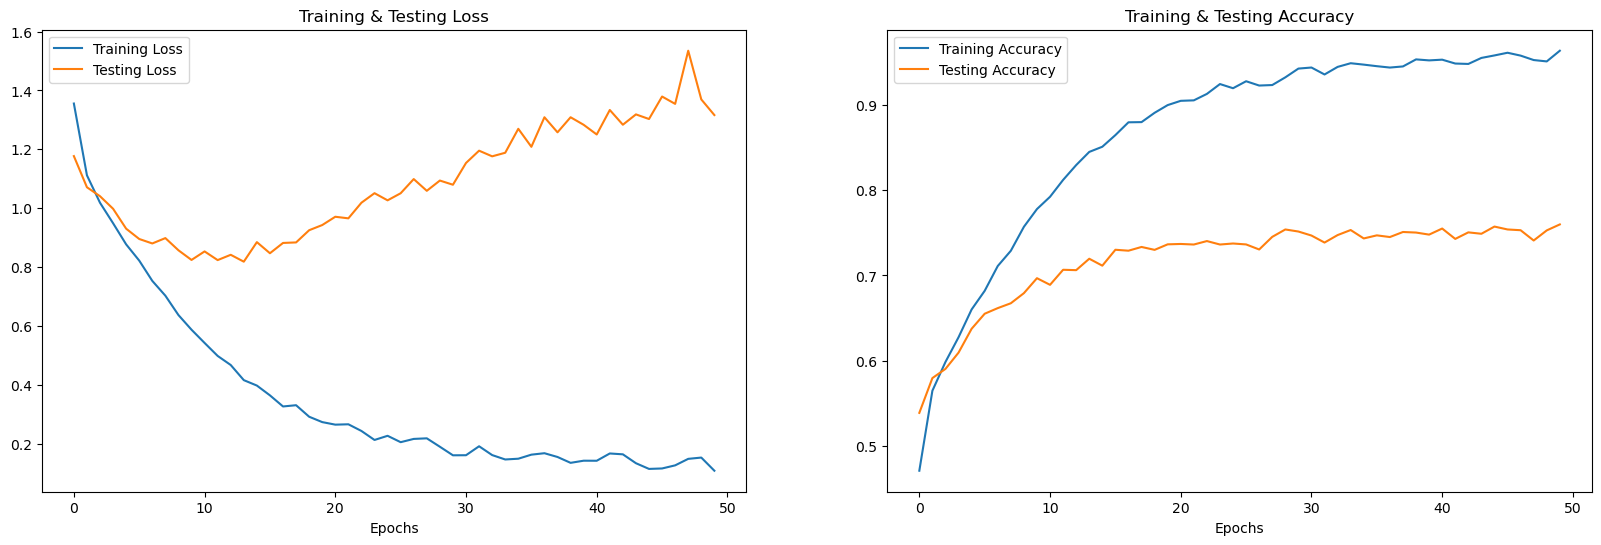

In [395]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [396]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

 26/286 [=>............................] - ETA: 1s

2024-05-05 09:32:38.519927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 1s 2ms/step


Predicted Labels Actual Labels
0             fear       neutral
1              sad           sad
2            happy          fear
3          disgust       disgust
4              sad           sad
5          neutral       neutral
6             fear          fear
7          neutral       neutral
8              sad           sad
9             fear          fear

In [2]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

NameError: name 'confusion_matrix' is not defined

In [1]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to DataFrame for better visualization
cm_normalized_df = pd.DataFrame(cm_normalized, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized_df, annot=True, cmap='Blues', fmt='.2%')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

NameError: name 'confusion_matrix' is not defined

In [398]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.86      0.84      0.85      1436
        calm       0.89      0.88      0.89       149
     disgust       0.72      0.70      0.71      1426
        fear       0.71      0.71      0.71      1388
       happy       0.73      0.77      0.75      1465
     neutral       0.72      0.76      0.74      1304
         sad       0.76      0.73      0.74      1455
    surprise       0.92      0.90      0.91       499

    accuracy                           0.76      9122
   macro avg       0.79      0.78      0.79      9122
weighted avg       0.76      0.76      0.76      9122



### Predicting Gender and Emotion

In [30]:
dataset

Path     Sex   Emotion
0      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
1      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
2      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female      fear
3      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female     angry
4      /Users/gabrielcha/Documents/ser/data_ravdess/A...  female   disgust
...                                                  ...     ...       ...
12157  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12158  /Users/gabrielcha/Documents/ser/data_savee/JE_...    male     angry
12159  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male   neutral
12160  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise
12161  /Users/gabrielcha/Documents/ser/data_savee/DC_...    male  surprise

[12162 rows x 3 columns]

In [242]:
X, Y_emotion, Y_sex = [], [], []
for path, emotion, sex in zip(dataset.Path, dataset.Emotion, dataset.Sex):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y_emotion.append(emotion)
        Y_sex.append(sex)

In [32]:
ensemble_Features = pd.read_csv('features.csv')
# ensemble_Features['labels_emotion'] = Y_emotion
# ensemble_Features['labels_sex'] = Y_sex
# ensemble_Features.to_csv('features.csv', index=False)
# ensemble_Features

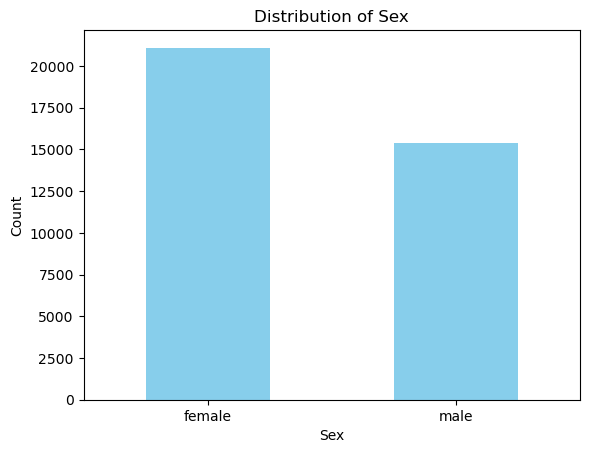

In [33]:
# Count the occurrences of each category
sex_counts = ensemble_Features['labels_sex'].value_counts()

# Create a bar chart
sex_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.xticks(rotation=0)  # Rotates labels to be horizontal
plt.show()

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Prepare input features
X = ensemble_Features.iloc[:, :162].values  # assuming your features are the first 161 columns

# Prepare labels
label_encoder_emotion = LabelEncoder()
label_encoder_sex = LabelEncoder()

Y_emotion = label_encoder_emotion.fit_transform(ensemble_Features['labels_emotion'])
Y_sex = label_encoder_sex.fit_transform(ensemble_Features['labels_sex'])

# Convert labels to categorical (one-hot encoding)
Y_emotion = to_categorical(Y_emotion)
Y_sex = to_categorical(Y_sex)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, Y_emotion_train, Y_emotion_test, Y_sex_train, Y_sex_test = train_test_split(
    X_scaled, Y_emotion, Y_sex, test_size=0.2, random_state=42)


### Ensemble of Nerual Networks

In [35]:
# ensemble_Features
ensemble_Features = ensemble_Features.sample(frac=1).reset_index(drop=True) 
ensemble_Features

0         1         2         3         4         5         6  \
0      0.160218  0.393615  0.374550  0.423135  0.412984  0.376003  0.419065   
1      0.041479  0.629989  0.679520  0.686580  0.569304  0.654222  0.706284   
2      0.143252  0.395696  0.355040  0.348531  0.373021  0.388231  0.388090   
3      0.144023  0.647753  0.687585  0.614053  0.612520  0.673141  0.697294   
4      0.052246  0.370399  0.608733  0.936036  0.632534  0.348476  0.269778   
...         ...       ...       ...       ...       ...       ...       ...   
36481  0.089927  0.526970  0.357136  0.347631  0.387093  0.376005  0.331732   
36482  0.118594  0.506212  0.657845  0.758227  0.719550  0.677727  0.601138   
36483  0.041532  0.557470  0.605413  0.575485  0.520279  0.495899  0.514957   
36484  0.145046  0.618691  0.570120  0.534283  0.543848  0.588863  0.611050   
36485  0.307329  0.773869  0.785120  0.764668  0.842758  0.828613  0.721011   

              7         8         9  ...           154           155  \
0      0.597197  0.720335  0.603406  ...  6.644932e-04  6.336987e-04   
1      0.675703  0.560395  0.618077  ...  5.728402e-08  5.324025e-08   
2      0.404467  0.521402  0.674889  ...  4.714120e-03  4.112915e-03   
3      0.740714  0.664395  0.698997  ...  3.248594e-04  3.200847e-04   
4      0.277974  0.249357  0.299235  ...  2.123694e-04  1.178336e-04   
...         ...       ...       ...  ...           ...           ...   
36481  0.364256  0.431938  0.495618  ...  5.999029e-04  5.118370e-04   
36482  0.572350  0.545510  0.548221  ...  4.391173e-04  5.634652e-04   
36483  0.605739  0.565994  0.610877  ...  3.049696e-09  2.888214e-09   
36484  0.634264  0.680431  0.672524  ...  3.339702e-04  2.782047e-04   
36485  0.696871  0.707606  0.747398  ...  1.364057e-02  1.444173e-02   

                156           157           158           159           160  \
0      8.331904e-04  5.031513e-04  8.142100e-04  8.001917e-04  1.008146e-03   
1      5.022216e-08  4.796099e-08  4.631435e-08  4.511227e-08  4.431879e-08   
2      5.131136e-03  6.736737e-03  6.633130e-03  4.462711e-03  2.128743e-03   
3      3.097467e-04  3.302762e-04  3.192803e-04  3.009948e-04  2.881403e-04   
4      1.216871e-04  1.243439e-04  1.007557e-04  9.555069e-05  3.947944e-05   
...             ...           ...           ...           ...           ...   
36481  5.088542e-04  6.288669e-04  5.977194e-04  5.207765e-04  5.257775e-04   
36482  8.079049e-04  7.452829e-04  6.927551e-04  9.038761e-04  6.673649e-04   
36483  2.768364e-09  2.679520e-09  2.616163e-09  2.570359e-09  2.541050e-09   
36484  2.599402e-04  2.468991e-04  1.889709e-04  1.248628e-04  1.069574e-04   
36485  1.297883e-02  1.312699e-02  1.372736e-02  1.373006e-02  1.353957e-02   

                161  labels_emotion  labels_sex  
0      1.263356e-04             sad      female  
1      4.383218e-08           happy        male  
2      2.061524e-04           happy      female  
3      3.016520e-04             sad      female  
4      2.927691e-05            fear      female  
...             ...             ...         ...  
36481  4.595830e-04           happy      female  
36482  2.804844e-05         disgust        male  
36483  2.522848e-09         disgust      female  
36484  8.882200e-05        surprise      female  
36485  1.376291e-02           happy        male  

[36486 rows x 164 columns]

In [36]:
# Prepare input features
X = ensemble_Features.iloc[:, :162].values  # All columns except the last two

# Prepare labels
label_encoder_emotion = LabelEncoder()
label_encoder_sex = LabelEncoder()

Y_emotion = label_encoder_emotion.fit_transform(ensemble_Features['labels_emotion'])
Y_sex = label_encoder_sex.fit_transform(ensemble_Features['labels_sex'])

# Convert labels to categorical (one-hot encoding)
Y_emotion = to_categorical(Y_emotion)
Y_sex = to_categorical(Y_sex)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [37]:
# Split the dataset into training and testing sets
X_train, X_test, Y_emotion_train, Y_emotion_test, Y_sex_train, Y_sex_test = train_test_split(
    X_scaled, Y_emotion, Y_sex, test_size=0.2, random_state=42)


In [38]:
# Find indices for male and female in the training data
male_indices = np.where(np.argmax(Y_sex_train, axis=1) == 1)[0]  # Assuming '1' is male
female_indices = np.where(np.argmax(Y_sex_train, axis=1) == 0)[0]  # Assuming '0' is female

# Create gender-specific training subsets for emotions
X_train_male = X_train[male_indices]
Y_emotion_train_male = Y_emotion_train[male_indices]

X_train_female = X_train[female_indices]
Y_emotion_train_female = Y_emotion_train[female_indices]


In [39]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model

def create_base_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(256, 5, padding='same', activation='relu')(input_layer)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling1D(pool_size=(8))(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Flatten()(x)
    return x, input_layer

# Create the base model
x, input_layer = create_base_model((X_train.shape[1], 1))


In [40]:
def create_gender_model(base_model, num_genders):
    gender_output = Dense(num_genders, activation='softmax', name='gender_output')(base_model)
    model = Model(inputs=input_layer, outputs=gender_output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the gender model
gender_model = create_gender_model(x, Y_sex_train.shape[1])


In [41]:
def create_emotion_model(base_model, num_emotions):
    emotion_output = Dense(num_emotions, activation='softmax', name='emotion_output')(base_model)
    model = Model(inputs=input_layer, outputs=emotion_output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate emotion models for male and female
emotion_model_male = create_emotion_model(x, Y_emotion_train.shape[1])
emotion_model_female = create_emotion_model(x, Y_emotion_train.shape[1])

In [42]:
gender_model.fit(X_train, Y_sex_train, epochs=10, batch_size=64, validation_data=(X_test, Y_sex_test))

Epoch 1/10


2024-06-01 16:59:58.686846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


457/457 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.9128

2024-06-01 17:00:04.394305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


457/457 [==============================] - 7s 14ms/step - loss: 0.2094 - accuracy: 0.9128 - val_loss: 0.1635 - val_accuracy: 0.9333
Epoch 2/10
457/457 [==============================] - 6s 14ms/step - loss: 0.1273 - accuracy: 0.9502 - val_loss: 0.1321 - val_accuracy: 0.9470
Epoch 3/10
457/457 [==============================] - 6s 14ms/step - loss: 0.1073 - accuracy: 0.9578 - val_loss: 0.1007 - val_accuracy: 0.9594
Epoch 4/10
457/457 [==============================] - 6s 14ms/step - loss: 0.0900 - accuracy: 0.9637 - val_loss: 0.0897 - val_accuracy: 0.9636
Epoch 5/10
457/457 [==============================] - 6s 14ms/step - loss: 0.0842 - accuracy: 0.9688 - val_loss: 0.0923 - val_accuracy: 0.9638
Epoch 6/10
457/457 [==============================] - 6s 14ms/step - loss: 0.0763 - accuracy: 0.9710 - val_loss: 0.0832 - val_accuracy: 0.9662
Epoch 7/10
457/457 [==============================] - 6s 14ms/step - loss: 0.0692 - accuracy: 0.9729 - val_loss: 0.0988 - val_accuracy: 0.9633
Epoch 8/10

In [43]:
emotion_model_male.fit(X_train_male, Y_emotion_train_male, epochs=30, batch_size=64, validation_data=(X_test, Y_emotion_test))

Epoch 1/30
  1/192 [..............................] - ETA: 55s - loss: 2.2027 - accuracy: 0.0781

2024-06-01 17:01:01.980268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - ETA: 0s - loss: 1.4936 - accuracy: 0.4124

2024-06-01 17:01:04.662191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 4s 18ms/step - loss: 1.4936 - accuracy: 0.4124 - val_loss: 1.8340 - val_accuracy: 0.3705
Epoch 2/30
192/192 [==============================] - 3s 17ms/step - loss: 1.2669 - accuracy: 0.5025 - val_loss: 1.9413 - val_accuracy: 0.3802
Epoch 3/30
192/192 [==============================] - 3s 17ms/step - loss: 1.1366 - accuracy: 0.5611 - val_loss: 2.0587 - val_accuracy: 0.3944
Epoch 4/30
192/192 [==============================] - 3s 17ms/step - loss: 1.0226 - accuracy: 0.6038 - val_loss: 2.3143 - val_accuracy: 0.3963
Epoch 5/30
192/192 [==============================] - 3s 17ms/step - loss: 0.9287 - accuracy: 0.6452 - val_loss: 2.6271 - val_accuracy: 0.4049
Epoch 6/30
192/192 [==============================] - 3s 16ms/step - loss: 0.8398 - accuracy: 0.6815 - val_loss: 2.6426 - val_accuracy: 0.4074
Epoch 7/30
192/192 [==============================] - 3s 17ms/step - loss: 0.7626 - accuracy: 0.7156 - val_loss: 2.8678 - val_accuracy: 0.4156
Epoch 8/30

In [44]:
emotion_model_female.fit(X_train_female, Y_emotion_train_female, epochs=30, batch_size=64, validation_data=(X_test, Y_emotion_test))

Epoch 1/30
  5/265 [..............................] - ETA: 3s - loss: 2.7136 - accuracy: 0.2125  

2024-06-01 17:02:38.401889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


265/265 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.6120

2024-06-01 17:02:41.862414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


265/265 [==============================] - 4s 16ms/step - loss: 1.0499 - accuracy: 0.6120 - val_loss: 1.3353 - val_accuracy: 0.5414
Epoch 2/30
265/265 [==============================] - 4s 15ms/step - loss: 0.7071 - accuracy: 0.7310 - val_loss: 1.3199 - val_accuracy: 0.5623
Epoch 3/30
265/265 [==============================] - 4s 15ms/step - loss: 0.5618 - accuracy: 0.7834 - val_loss: 1.5127 - val_accuracy: 0.5702
Epoch 4/30
265/265 [==============================] - 4s 15ms/step - loss: 0.4498 - accuracy: 0.8319 - val_loss: 1.5634 - val_accuracy: 0.5847
Epoch 5/30
265/265 [==============================] - 4s 15ms/step - loss: 0.3741 - accuracy: 0.8595 - val_loss: 1.6719 - val_accuracy: 0.5881
Epoch 6/30
265/265 [==============================] - 4s 15ms/step - loss: 0.3396 - accuracy: 0.8775 - val_loss: 1.8327 - val_accuracy: 0.5896
Epoch 7/30
265/265 [==============================] - 4s 15ms/step - loss: 0.2596 - accuracy: 0.9040 - val_loss: 1.8656 - val_accuracy: 0.5959
Epoch 8/30

In [45]:
# Predict gender on the test data
gender_predictions_test = gender_model.predict(X_test)
gender_pred_classes_test = np.argmax(gender_predictions_test, axis=1)

# Predict emotions using the appropriate model based on predicted gender
emotion_predictions_test = np.zeros_like(Y_emotion_test)

for i in range(len(X_test)):
    if gender_pred_classes_test[i] == 1:  # '1' is male
        emotion_predictions_test[i] = emotion_model_male.predict(np.expand_dims(X_test[i], axis=0), verbose = 0)
    else:  # '0' is female
        emotion_predictions_test[i] = emotion_model_female.predict(np.expand_dims(X_test[i], axis=0),verbose = 0)

emotion_pred_classes_test = np.argmax(emotion_predictions_test, axis=1)

 59/229 [======>.......................] - ETA: 0s

2024-06-01 17:04:41.244910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 1s 2ms/step


2024-06-01 17:04:41.892770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-01 17:04:41.974685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate Gender Model Accuracy
gender_accuracy = accuracy_score(np.argmax(Y_sex_test, axis=1), gender_pred_classes_test)
print(f"Gender Classification Accuracy: {gender_accuracy * 100:.2f}%")

# Evaluate Emotion Model Accuracy
emotion_accuracy = accuracy_score(np.argmax(Y_emotion_test, axis=1), emotion_pred_classes_test)
print(f"Emotion Classification Accuracy: {emotion_accuracy * 100:.2f}%")

# Additional metrics
print("\nGender Classification Report:")
print(classification_report(np.argmax(Y_sex_test, axis=1), gender_pred_classes_test))

print("Emotion Classification Report:")
print(classification_report(np.argmax(Y_emotion_test, axis=1), emotion_pred_classes_test))


Gender Classification Accuracy: 81.24%
Emotion Classification Accuracy: 59.77%

Gender Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      4151
           1       0.74      0.88      0.80      3147

    accuracy                           0.81      7298
   macro avg       0.81      0.82      0.81      7298
weighted avg       0.83      0.81      0.81      7298

Emotion Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      1173
           1       0.83      0.16      0.26       121
           2       0.51      0.57      0.54      1181
           3       0.52      0.59      0.55      1178
           4       0.60      0.52      0.56      1124
           5       0.68      0.52      0.59      1022
           6       0.53      0.58      0.55      1121
           7       0.84      0.80      0.82       378

    accuracy                           0.60 

In [53]:
emotion_pred_classes_test

array([6, 2, 2, ..., 6, 6, 6])

In [57]:
np.argmax(Y_emotion_test, axis=1)

array([3, 2, 6, ..., 6, 6, 3])

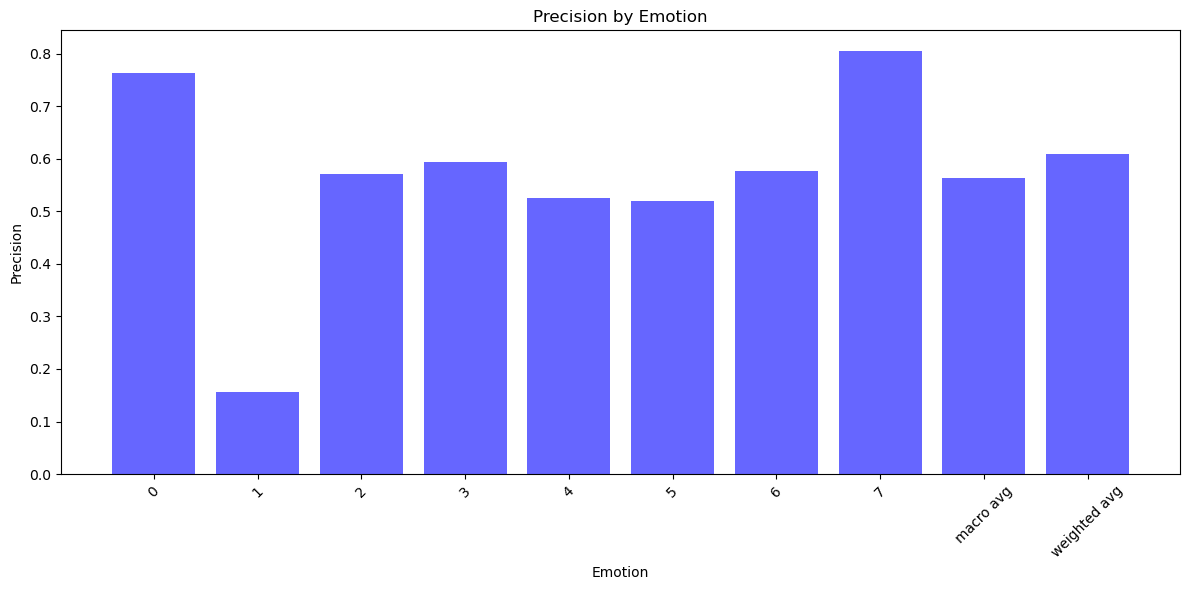

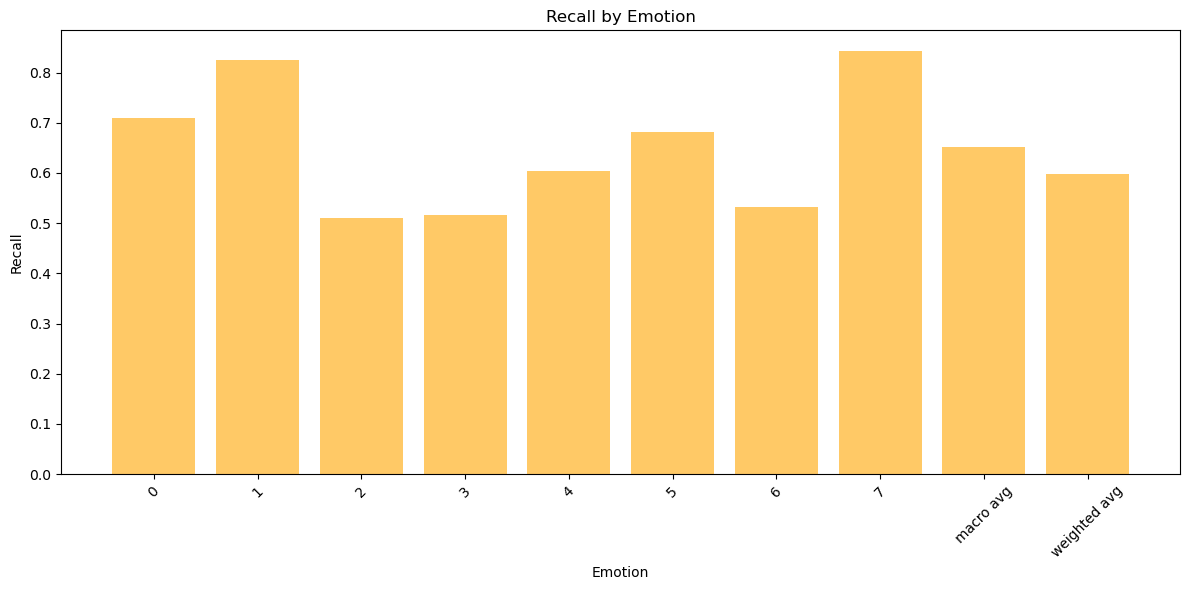

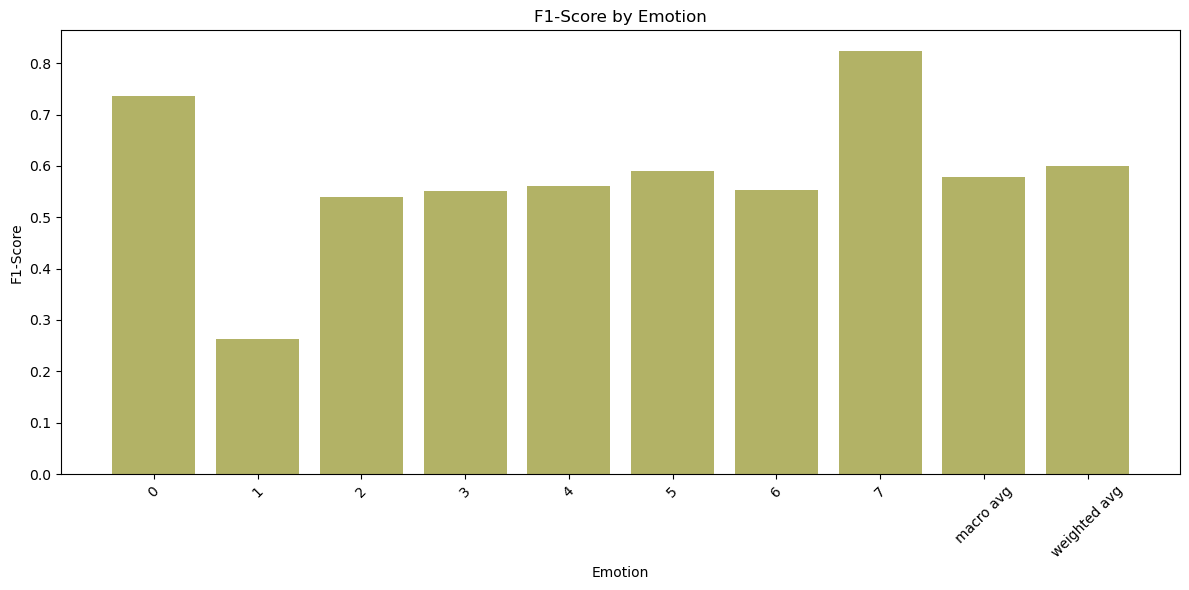

In [58]:


report = classification_report(emotion_pred_classes_test, np.argmax(Y_emotion_test, axis=1), output_dict=True)
emotion_data = {
    "emotion": [],
    "precision": [],
    "recall": [],
    "f1-score": [],
    "support": []
}

for emotion, metrics in report.items():
    if isinstance(metrics, dict):
        emotion_data["emotion"].append(emotion)
        emotion_data["precision"].append(metrics.get("precision", 0))
        emotion_data["recall"].append(metrics.get("recall", 0))
        emotion_data["f1-score"].append(metrics.get("f1-score", 0))
        emotion_data["support"].append(metrics.get("support", 0))

df = pd.DataFrame(emotion_data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['precision'], color='blue', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('Precision')
ax.set_title('Precision by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting recall
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['recall'], color='orange', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('Recall')
ax.set_title('Recall by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting F1-score
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['f1-score'], color='olive', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
report = classification_report(emotion_pred_classes_test, np.argmax(Y_emotion_test, axis=1), output_dict=True)
report

{'0': {'precision': 0.763000852514919,
  'recall': 0.7103174603174603,
  'f1-score': 0.7357172215371968,
  'support': 1260},
 '1': {'precision': 0.15702479338842976,
  'recall': 0.8260869565217391,
  'f1-score': 0.2638888888888889,
  'support': 23},
 '2': {'precision': 0.5715495342929721,
  'recall': 0.5109765329295988,
  'f1-score': 0.539568345323741,
  'support': 1321},
 '3': {'precision': 0.5942275042444821,
  'recall': 0.5154639175257731,
  'f1-score': 0.5520504731861198,
  'support': 1358},
 '4': {'precision': 0.5249110320284698,
  'recall': 0.6032719836400818,
  'f1-score': 0.5613701236917222,
  'support': 978},
 '5': {'precision': 0.5205479452054794,
  'recall': 0.6820512820512821,
  'f1-score': 0.590455049944506,
  'support': 780},
 '6': {'precision': 0.5771632471008028,
  'recall': 0.5316351684470009,
  'f1-score': 0.5534644995722839,
  'support': 1217},
 '7': {'precision': 0.8042328042328042,
  'recall': 0.8421052631578947,
  'f1-score': 0.8227334235453315,
  'support': 361},